## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel, SignalKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

## Inputs

In [3]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#10000 toys - created from smoothed data with Poisson noise
toyList = np.load("newoutputs/toyList.npy")
fixedHyperparams = np.load("newoutputs/fixedHyperparams.npy")

#injected gaussian signals 
sigToys = np.load("newoutputs/signalToys.npy")
sigToysO = np.load("newoutputs/signalToysO.npy")
standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]

### Calculate z values and chi squared 

In [4]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2


### poisson likelihood

In [5]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### remove zero count bins to use for GP fits. Add back in zero bins for final prediction

In [6]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

def addZeros(data, xtoy):
    for ik, k in enumerate(xvalO):
        if ik <len(xtoy):
            if k == xtoy[ik]:
                continue
            else:
                if ik <= len(xtoy):
                    xtoy = np.insert(xtoy, ik, k)
                    data = np.insert(data, ik, 0)
        else:
            xtoy = np.append(xtoy, k)
            data = np.append(data, 0)
    return data, xtoy

## signal+background and background only plotted together

In [7]:
def makePrettyPlots_sb(xs_l, xs, ys_b, ys_sb, bkgs, bkgs_l, bkgsigs,xlow, title, ymax = 3e5):
    #f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, ys_sb, marker='o', ls='None', yerr = np.sqrt(ys_sb), c='black', markersize=10, label="Toy data with injected signal")
    bkg1Plot, = ax1.plot(xs_l, bkgs_l, color='g', linewidth=3.0, label="Gaussian Process background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='b', linewidth=3.0, label="Gaussian Process signal-plus-background")
    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.09, ymax])
    ax1.tick_params(axis='y', labelsize=25)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_sb, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=25)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("background-only fit residuals",(2020,-3.5), fontsize=25)

    
    zvals_2, chi2_2 = calcSignificance(ys_sb, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    #ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=25)
    ax3.tick_params(axis='x', labelsize=25)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("signal+background fit residuals",(2020,-3.5), fontsize=25)
    
    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)

    '''
    zvals_3, chi2_3 = calcSignificance(ys_b, bkgs)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    #ax4.set_ylabel('Significance', fontsize=15)
    ax4.set_ylabel('Sig.', fontsize=35, labelpad=23)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=25)
    ax4.tick_params(axis='x', labelsize=25)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])
    ax4.annotate("data vs bkg",(2520,-3.5), fontsize=25)
    
    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    '''

    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    


### signal only component of signal+background fit

In [8]:
def makePrettyPlots_signalOnly(xs, ys, bkgs, title, ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="Injected signal")
    bkgPlot, =ax1.plot(xs, bkgs, color='g', linewidth=3.0, label="Gaussian Process signal")#"Gaussian Process signal")
    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    #ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    #ax1.set_ylim([0.01, ymax])
    ax1.set_ylim([-2, 1.5*max(ys)])

    
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    h1.fillcolor = 'blue'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=35)
    ax2.tick_params(axis='y', labelsize=35)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    ax2.set_ylabel('Significance', fontsize=35, labelpad=23)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

In [9]:
def makePrettyPlots_signalOnly2(xs, dM_GP, GPs, data, sig, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=35, y=1.01)
    dataMinusGPbPlot = ax1.errorbar(xs, dM_GP, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Toy data - Gaussian Process background")
    dataPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")
    sigPlot = ax1.plot(xs, sig, linewidth=3.0, c='blue',label="Injected signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
    ax1.set_ylim([-3.5*max(GPs), 3.5*max(GPs)])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  
    #plt.gcf().subplots_adjust(top=0.1)
    #plt.tight_layout()
    #plt.savefig("testing.pdf")
    plt.show()

In [10]:
def makePrettyPlots_signalOnlysmooth(xs, xsmooth, dM_GP, GPs, data, sig, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=35, y=1.01)
    dataMinusGPbPlot = ax1.errorbar(xs, dM_GP, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Toy data - Gaussian Process background")
    dataPlot = ax1.plot(xsmooth, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")
    sigPlot = ax1.plot(xs, sig, linewidth=3.0, c='blue',label="Injected signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
    ax1.set_ylim([-3.5*max(GPs), 3.5*max(GPs)])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)  
    #plt.gcf().subplots_adjust(top=0.1)
    #plt.tight_layout()
    #plt.savefig("testing.pdf")
    plt.show()

In [11]:
def makePrettyPlots_signalOnly3(xs, data, GPs, mass, title):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=35, y=1.01)
    dataPlot = ax1.errorbar(xs, data, marker='o', ls='None', yerr = np.sqrt(data), c='black', markersize=10, label="Injected Signal")
    sigPlot = ax1.plot(xs, GPs, linewidth=3.0, c='green',label="Gaussian Process signal")


    ax1.legend(prop={'size':17})
    ax1.set_ylabel('Events per bin', fontsize=35)
    ax1.tick_params(axis='y', labelsize=35)
    ax1.set_xscale('log')

    ax1.set_xlim([max(mass*0.75, 1000), mass*1.5])
    ax1.set_ylim([-3, 1.5*max(GPs)])
    ax1.tick_params(axis='x', labelsize=35)
    major_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 1000)
    ax1.set_xticks(major_ticks)

    minor_ticks = np.arange((int(max(mass*0.75, 1000))/1000)*1000., (int(mass*1.5)/1000)*1000.+1000., 100)
    ax1.set_xticks(minor_ticks, minor=True)  

    labels = [str(int(j)/1000) for j in major_ticks]
    ax1.set_xticklabels(labels)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=35)
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    #plt.savefit("~/Desktop/testing.pdf")
    plt.show()

### Mean function for GP

In [12]:
def model_gp(params, t, xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

### Fit signal GP hyperparameters by minimizing george likelihood with minuit. Keep hyperparameters for background GP fixed

In [13]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

### Basic plot of data

In [14]:
def basicPlot(xs, ys, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(10,10))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10)
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_ylim([0.01, 2e6])
    
    ax1.set_xscale('log')
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)

### piecewise linear function for signal

In [15]:
def peak(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    slope=0.5
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center: 
            output[i]=(slope*c-slope*center+amp)
        if c > center and c < center+width:
            output[i]=(-slope*c+slope*center+amp)
    output = [s if s > 0 else 0 for s in output]
    return output

### right triangle function for signal

In [16]:
def triangle(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    offset=10.
    slope1 = amp/(2.*width-offset)
    y1 = amp*(-center+width)/(2*width-offset)
    slope2 = -amp/offset
    y2 = amp*(center+width)/offset
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width-offset: 
            output[i]=slope1*c+y1
        if c > center+width-offset and c < center+width:
            output[i]=slope2*c+y2
    output = [s if s > 0 else 0 for s in output]
    return output

### square signal function

In [17]:
def square(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width: output[i]=amp
    return output

### Gaussian signal function

In [18]:
def gaus(x, amp, center, width, xerr):
    return amp*(np.exp(-(x-center)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xerr

### Smearing functions - use Gaussian kernel to smooth out signals

In [19]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smearO(s, signal_shape):
    smeared_counts=np.zeros(len(xvalO))
    for xi, x in enumerate(xvalO):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [20]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smear(s, signal_shape):
    smeared_counts=np.zeros(len(xval))
    for xi, x in enumerate(xval):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

### Fit GP, break about into signal and background components

In [21]:
def makeGP(ycounts, xxs, xxserr):
    Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp 
    lnProb = logLike_gp_fitgpsig(xxs, ycounts, xxserr)
    bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, True)
    if np.isinf(bestval): 
        print "failed"
        return np.inf, np.inf, np.inf, np.inf
        
    A, mass, tau = best_fit_new 
    print "A, mas, tau", A, mass, tau
    
    kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
    kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

    
    kernel = kernel1 + kernel2
    gp = george.GP(kernel)
    gp.compute(xxs, np.sqrt(ycounts))
    meanGPp = gp.predict( ycounts - model_gp((p0,p1,p2),xxs, xxserr), xxs)[0]
    meanGP = meanGPp + model_gp((p0,p1,p2),xxs,xxserr)

    gp2 = george.GP(kernel)
    gp2.compute(xxs, np.sqrt(ycounts))
    K1 = kernel1.get_value(np.atleast_2d(xxs).T)
    mu1 = np.dot(K1, gp2.solver.apply_inverse(ycounts- model_gp((p0,p1,p2),xxs, xxserr))) + model_gp((p0,p1, p2),xxs,  xxserr)
    K2 = kernel2.get_value(np.atleast_2d(xxs).T)
    mu2 = np.dot(K2, gp2.solver.apply_inverse(ycounts- model_gp((p0,p1,p2),xxs, xxserr)))

    
    return meanGP, mu1, mu2, (A, mass, tau)

### Minimize george likelihood to fit background hyperparameters

In [22]:
class logLike_gp:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf

def fit_gp_minuit(lnprob, Print = True):
    passedFit = False
    minLLH = np.inf
    best_fit_params = (0, 0, 0, 0, 0, 0, 0, 0)
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1e6+1
        init1 = np.random.random() * 400.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 650.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1., error_decay = 0.1, error_length = 0.1, error_power = 0.1, 
                   error_sub = 0.1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (100., 1e15), limit_decay = (0, 500), limit_length = (0, 300), 
                   limit_power = (-200, 200), limit_sub = (0, 1000), limit_p0 = (0,10), 
                   limit_p1 = (-20, 20), limit_p2 = (-20,0)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
        
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params



### Gaussian signals

parameters (300, 3500, 250)
(1.0007082165697097, 1000.0000000002995, 100.00000000000024)
(589.9311805794745, 3555.179392283178, 197.0626833058775)
(587.5708456353505, 3555.168830780588, 196.92019005052677)
(588.7057996109529, 3555.1909688854266, 196.95001721639062)
A, mass, tau 588.705799611 3555.19096889 196.950017216


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.879101725


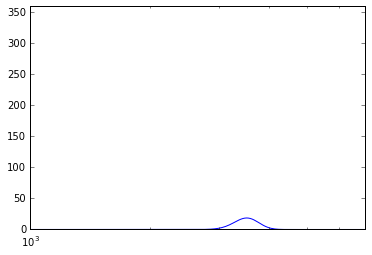

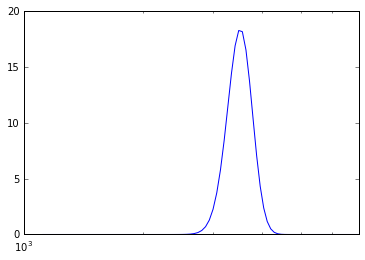

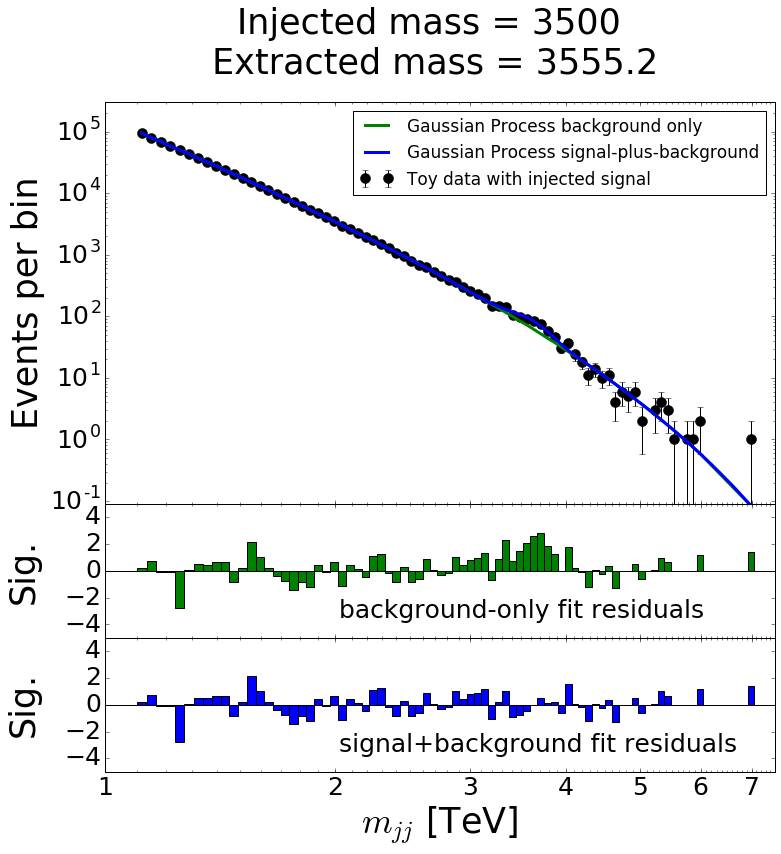

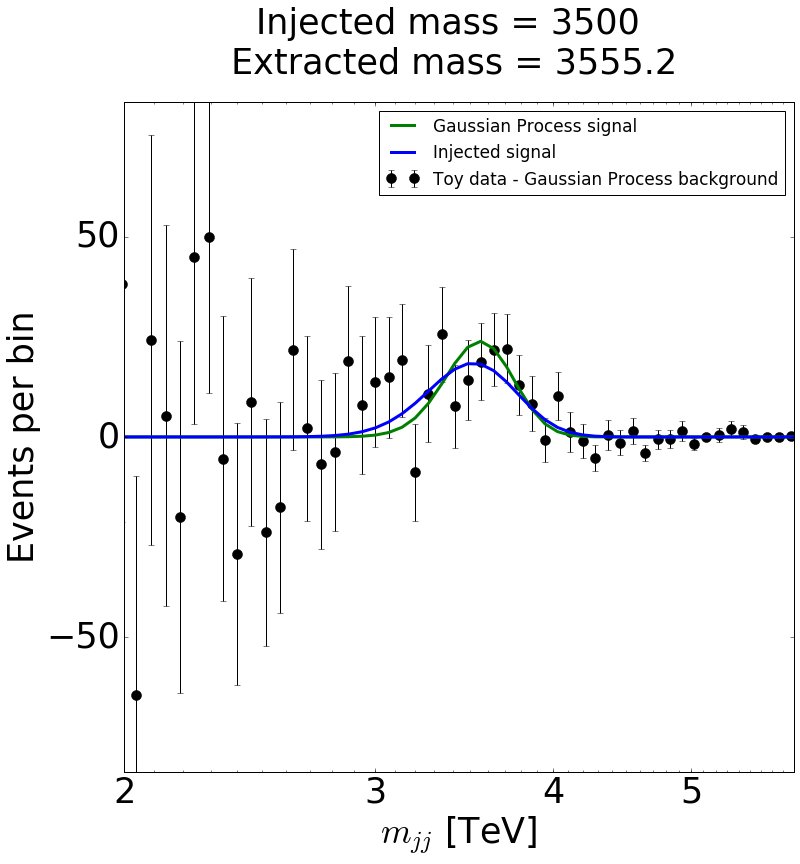

In [80]:
aa={}
mm={}
ww={}
#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        
        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)        
        

        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

### Peak signals

parameters (60, 3500, 250)
(1.0000000071220094, 2234.034879221961, 100.00000011002457)
(3237.8648346571767, 1779.3108654227203, 100.00000006493856)
(913.1190456336467, 3503.399642497962, 100.00000759865482)
(922.4688619372237, 3503.480341614893, 100.00000957207722)
(920.0061077809323, 3503.5090302325757, 100.00000059443053)
A, mass, tau 920.006107781 3503.50903023 100.000000594
chi2 bkg+signal mu=0 nan


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 69.953053201


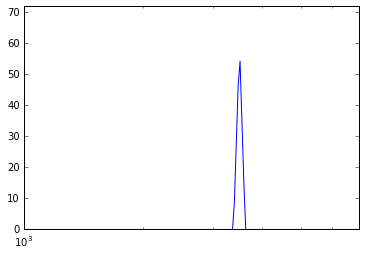

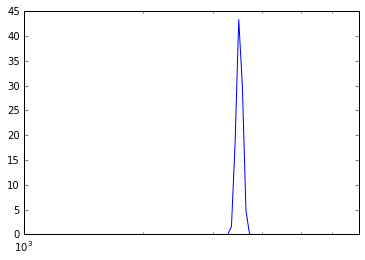

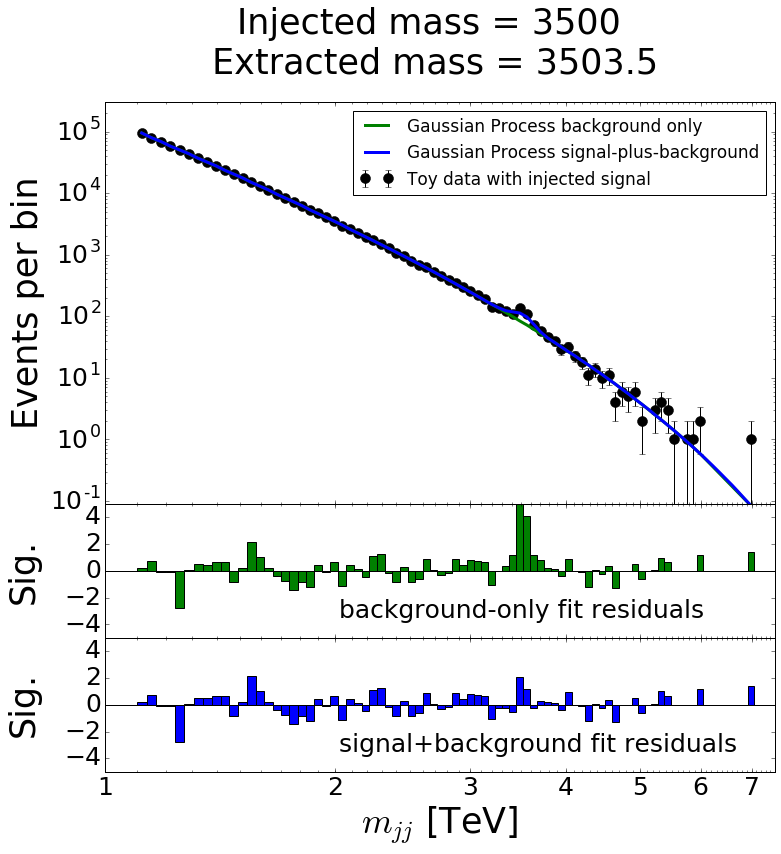

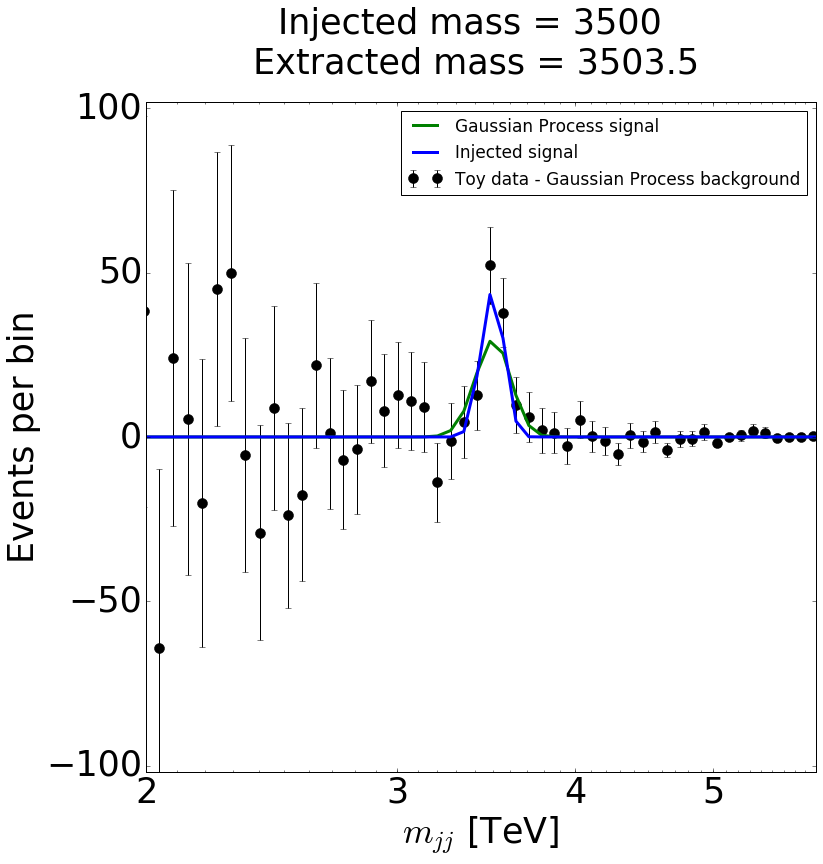

In [81]:
aa={}
mm={}
ww={}
#standardParamSets = [(200,2000,300), (100 ,2500, 250), (75, 3000, 250), (60, 3500, 250), (55, 4000, 250), 
#                     (45, 4500, 250), (40, 5000, 250), (25,5500, 250), (15, 6000,250)]
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### square signals

parameters (20, 3500, 250)
(3270.423420969928, 1779.2435315524135, 100.00000176531626)
(632.5830030158536, 3495.0206364161777, 188.29513420425076)
(632.8031815452881, 3495.0193897293198, 188.3025342395489)
(633.0079786771223, 3495.0204823964937, 188.2984928409298)
A, mass, tau 633.007978677 3495.0204824 188.298492841
chi2 bkg+signal mu=0 nan


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 67.2600980057


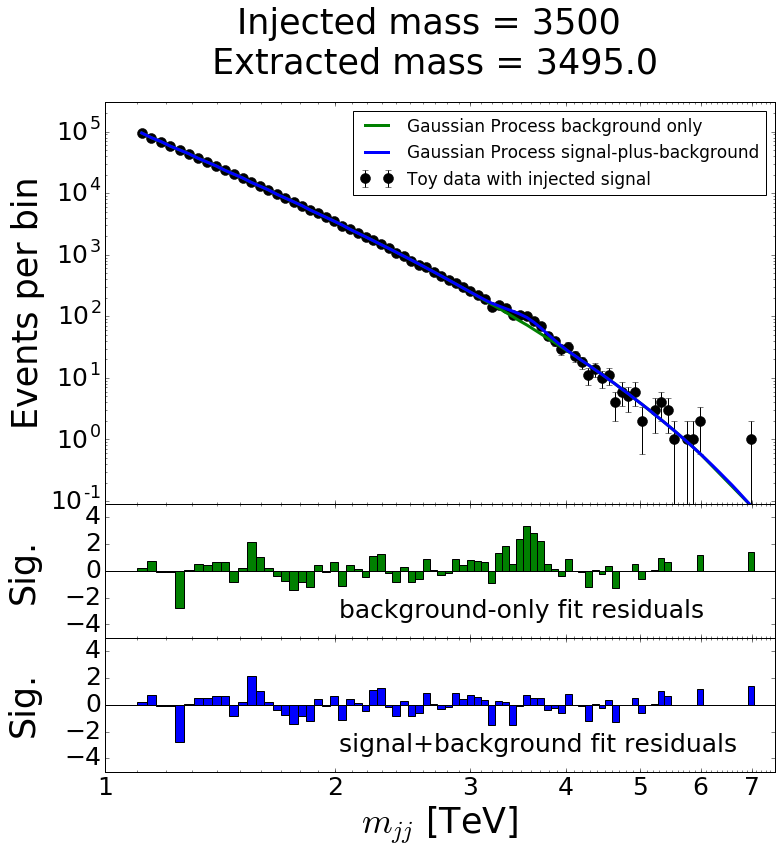

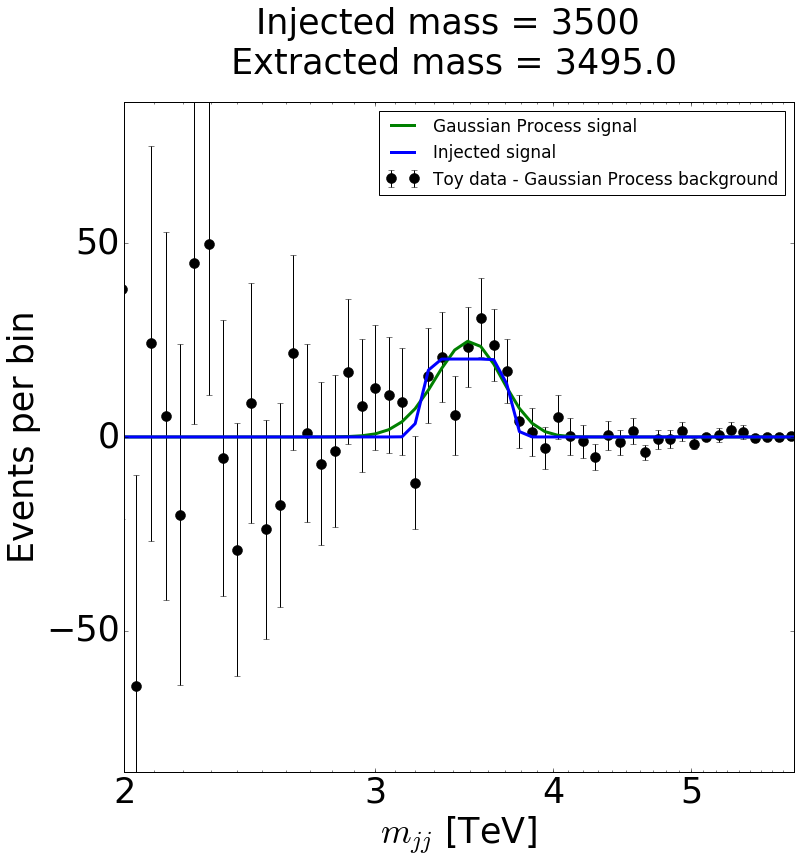

In [82]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



### Right Triangle

parameters (40, 3520, 250)
(1243.8134355152122, 3654.750203008871, 109.95012779940687)
A, mass, tau 1243.81343552 3654.75020301 109.950127799
chi2 bkg+signal mu=0 nan


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 67.5575338851


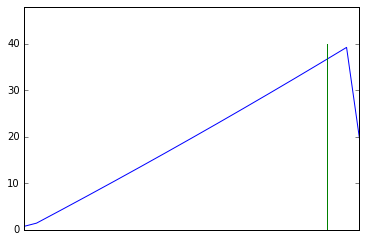

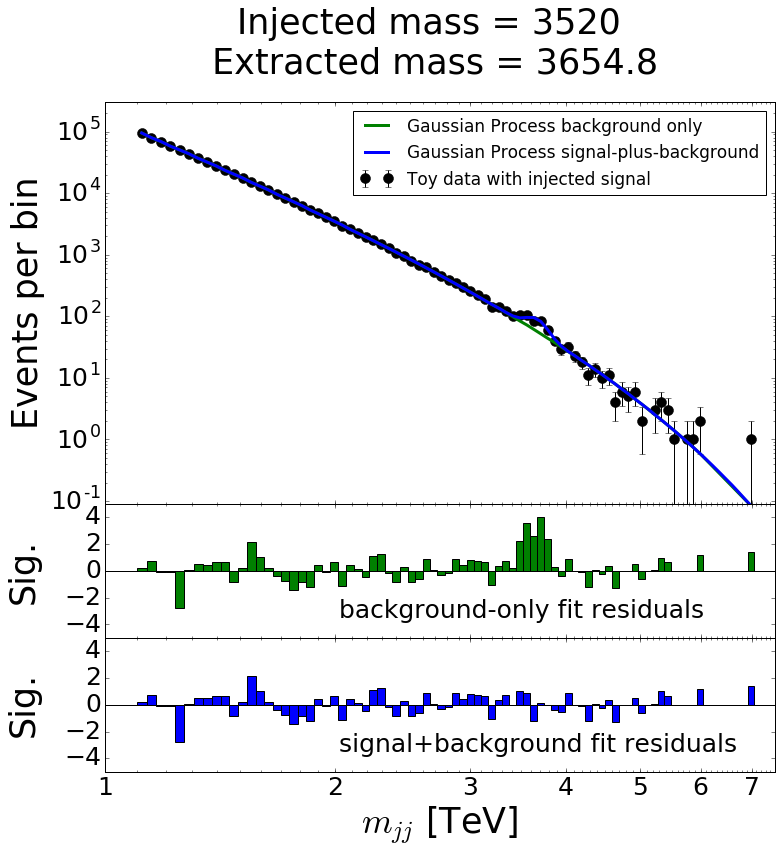

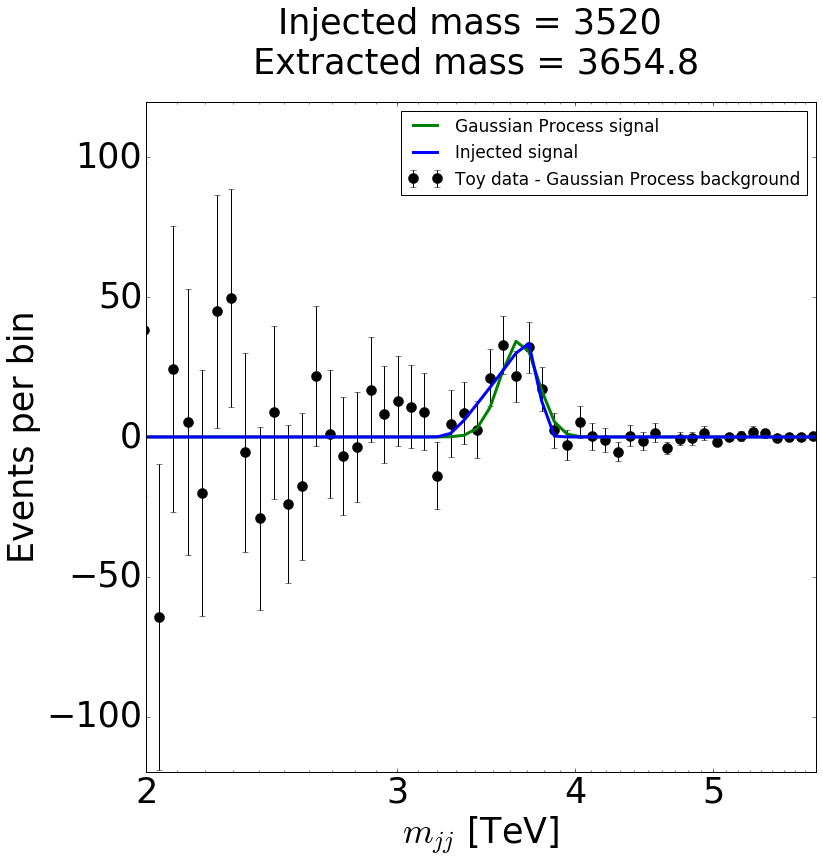

In [89]:

#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]

standardParamSets = [(40, 3520, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = triangle(truth_steps, n, m, w, truth_step_size)
        
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.plot((m+w-50.)*np.ones(2),[0, n]) 
        plt.xlim([m-w,m+w])
        plt.ylim([0,1.2*n])
        plt.xscale('log')
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 

        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)



In [ ]:
##########################################################

In [13]:
class logLike_gp_fitgpsigonly:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        kernel = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsigonly_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

parameters (300, 3500, 250)
(597.6075147970087, 3463.9747135580233, 112.50256195375988)
(608.1190536970772, 3463.8640471763265, 112.47972456362697)
(605.8467991628015, 3463.862773470914, 112.4888022643588)
(603.671624494709, 3463.9508861935046, 112.5064945770351)
(603.6766367227399, 3463.9534081108777, 112.50708457723934)
A, mass, tau 603.676636723 3463.95340811 112.507084577


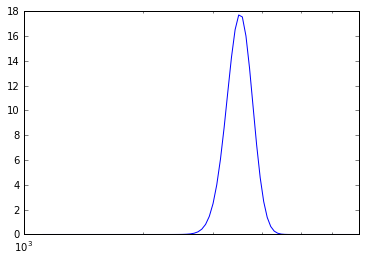

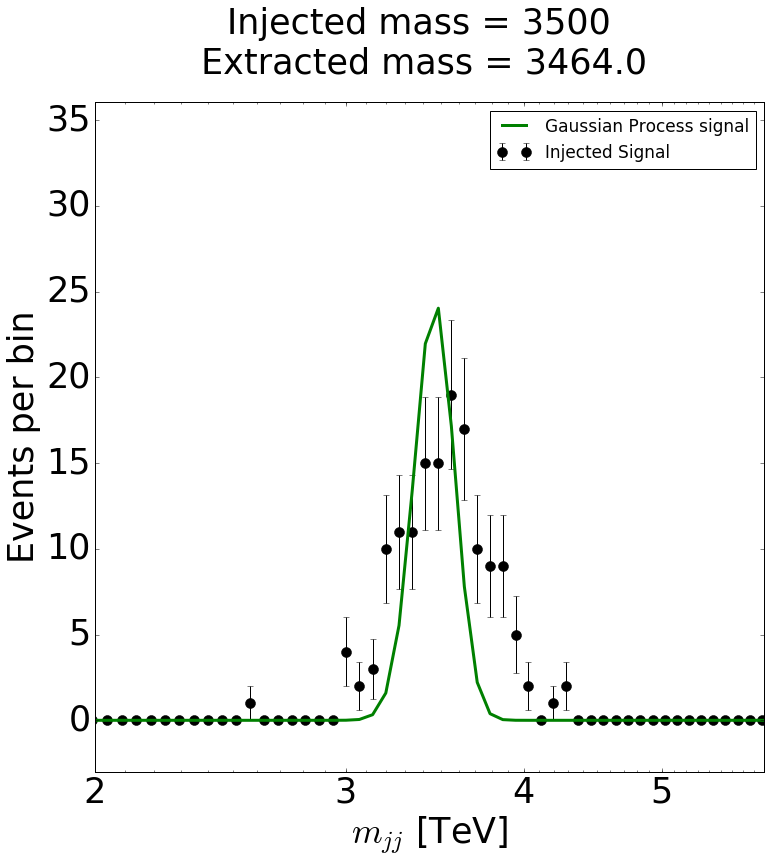

In [76]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]
standardParamSets=[(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)        
         
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        lnProb = logLike_gp_fitgpsigonly(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigonly_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)

        gp = george.GP(kernel2)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata, xvalO)[0]
        
       # newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
       # makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        

        makePrettyPlots_signalOnly3(xvalO, ydataO, meanGPp, m, label)


#makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        

In [ ]:
########################################################### NEW SIGNAL KERNEL##############

In [23]:
class logLike_gp_fitgpsigNew:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams 
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsigNew_minuit(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 1., error_mass = 1., error_tau = 1., error_L =10.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_L = (10, 10000))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

parameters (300, 3500, 250)
(59.11053826223365, 2267.413231175626, 100.03439748129792, 49.99161917846598)
(283.0138851958716, 3514.4408619182714, 269.01983671042376, 9963.51821199986)
(283.8936501775335, 3514.72991746185, 268.8541606470367, 9995.1813257842)
(283.53090341246894, 3514.8919884774336, 268.8616181910262, 9999.884733445842)
(282.99371753480375, 3514.8914333625785, 268.89134904215143, 9999.942460737133)
A, mass, tau, L 282.993717535 3514.89143336 268.891349042 9999.94246074


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.0556846823


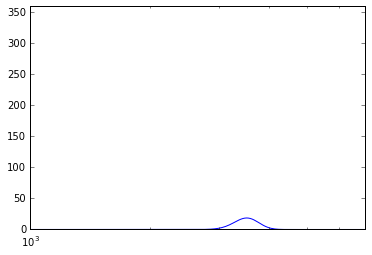

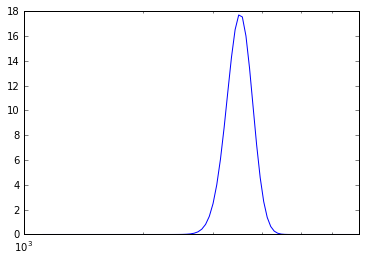

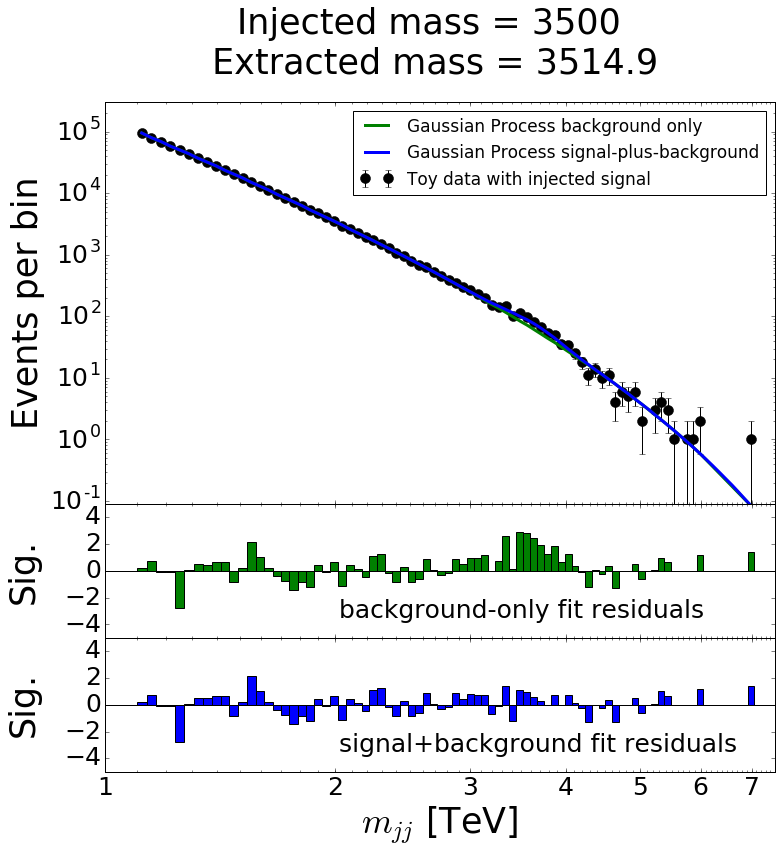

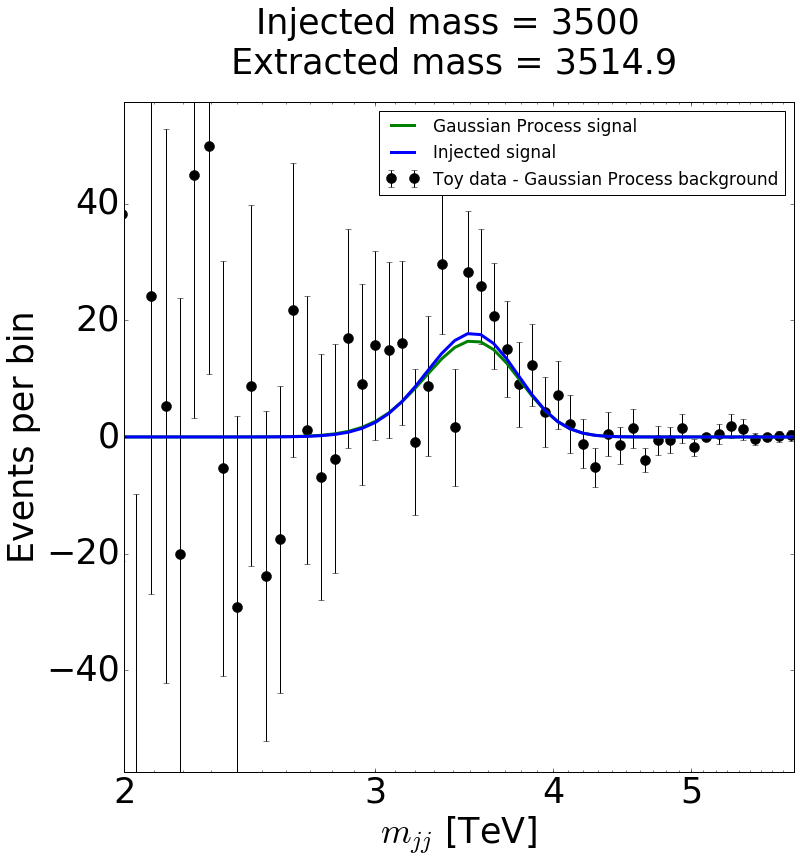

In [96]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

In [ ]:
#########no smearing or noise################

parameters (20, 3500, 250)
(743.3233698765329, 3544.1912962313127, 156.80267854624913, 9999.351933079897)
(743.4226652766657, 3544.1788386278395, 156.84524148344565, 9999.41655820002)
(742.4247617293662, 3544.207821426313, 156.8307202303796, 9999.948058745424)
A, mass, tau, L 742.424761729 3544.20782143 156.83072023 9999.94805875
chi2 bkg+signal mu=0 nan


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal 69.05486157


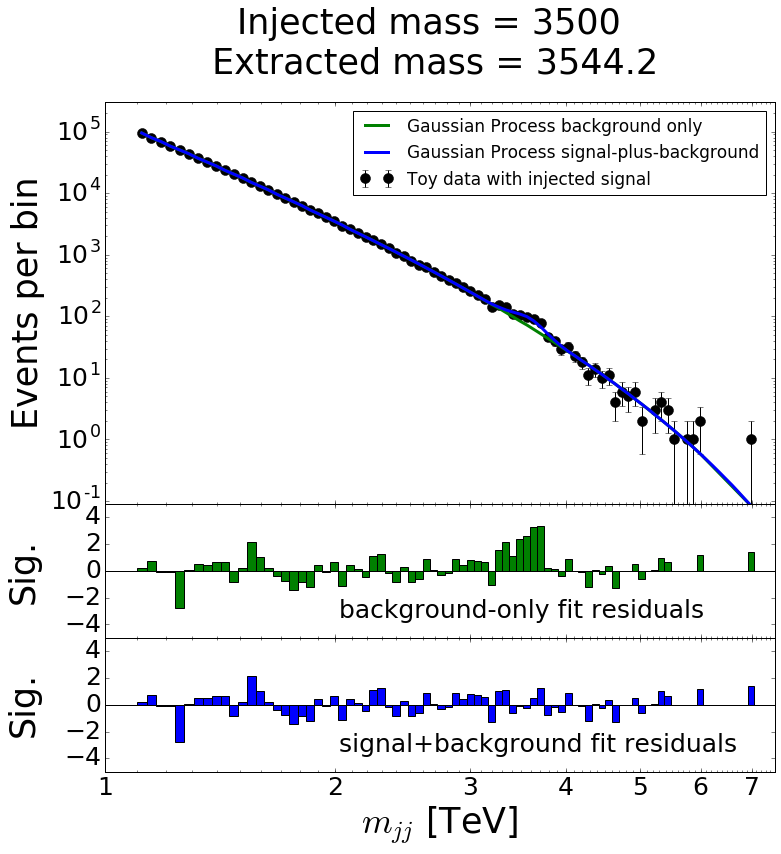

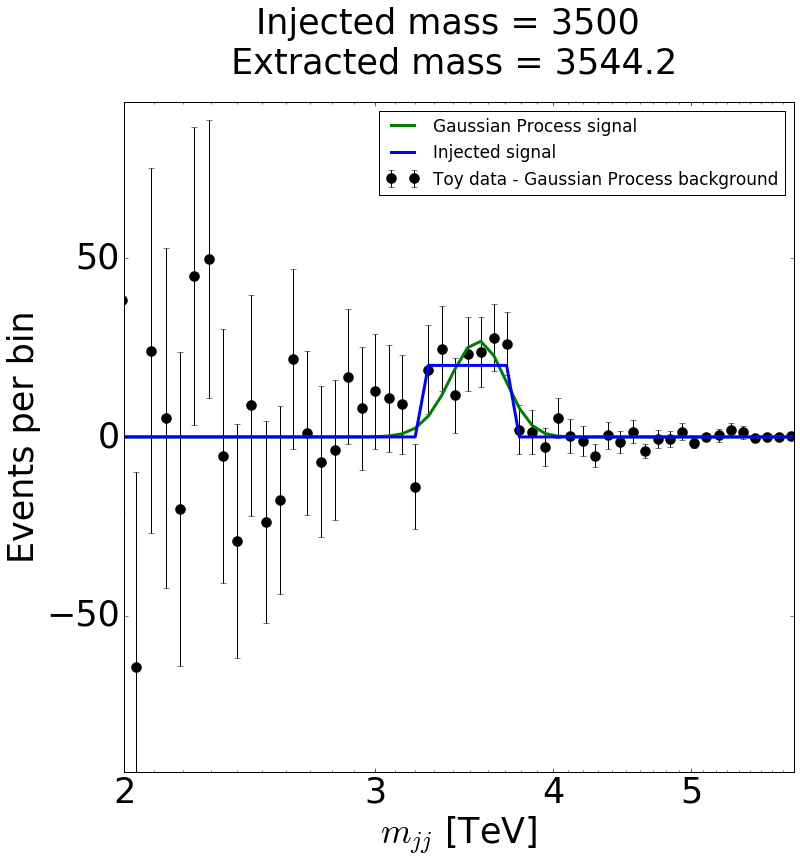

In [28]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(xtoy, n, m, w, xtoyerr)
        ydata = signal+ytoy
        
        signalO = square(xvalO, n, m, w, xerrO)
        ydataO = yvalO+signalO
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy, ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, signalO, m, label)
        

In [ ]:
############################

parameters (60, 3500, 250)
(11831.792551511724, 1651.9351495602152, 124.75927632288304, 100.28535382894027)
(790.3508712377226, 3508.6663520102247, 108.83319406659294, 4999.295553490437)
(790.9794592465678, 3508.6364364108063, 108.83324314547636, 4999.433554242517)
(790.8366388600999, 3508.623592769749, 108.84165482996298, 4999.873996892449)
A, mass, tau, L 790.83663886 3508.62359277 108.84165483 4999.87399689


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.923279996


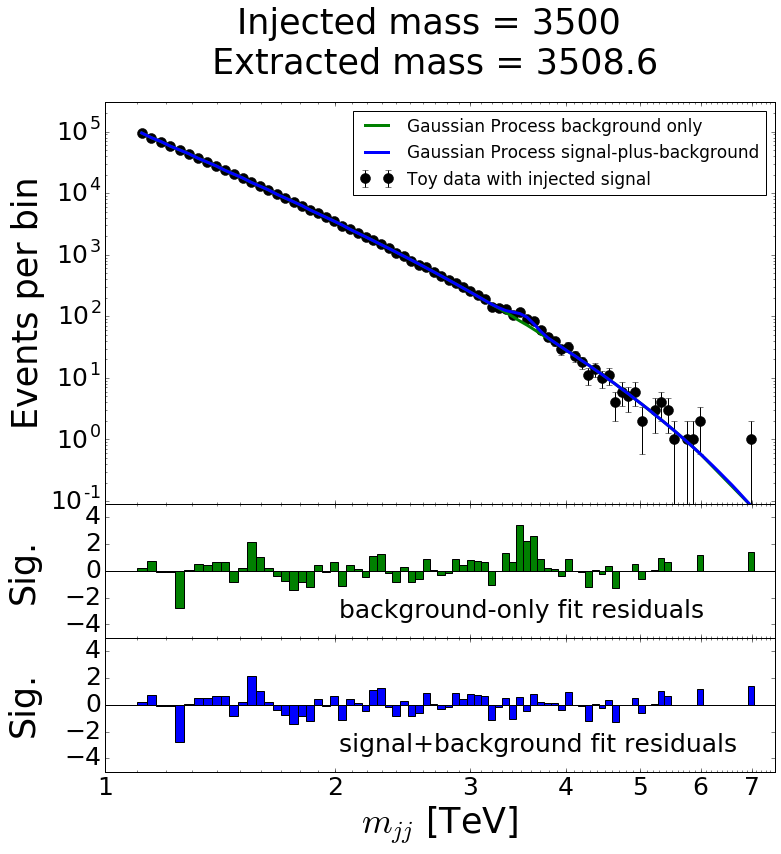

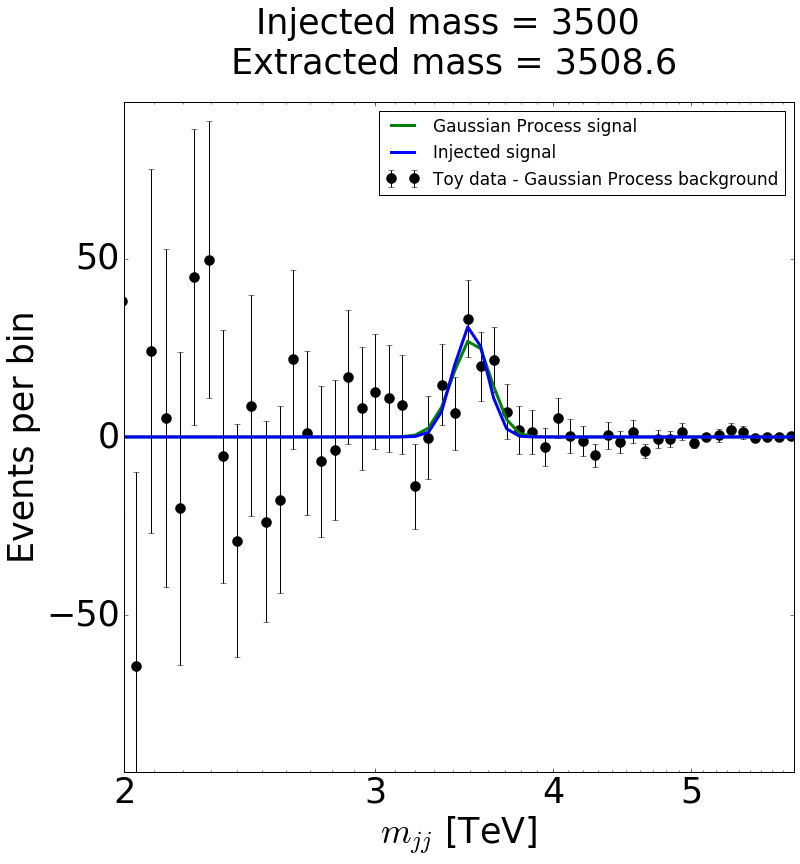

In [49]:
standardParamSets = [(60, 3500, 250)]

for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = peak(truth_steps, n, m, w, truth_step_size)

        
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO

        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 

        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        newys, newxs = addZeros(mu2, xtoy)


        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)




parameters (20, 3500, 250)
(3665.3190572747035, 1510.5356703478872, 100.00013393461114)
(3667.5009233319875, 1510.4062109827391, 100.00008370981992)
(747.11336057831, 3547.5280976079343, 165.2138501765139)
(749.4046462179343, 3547.4449761523, 165.25211761561084)
(749.5552012836009, 3547.4582535256463, 165.24208276083004)
(749.5221039484198, 3547.4561228451466, 165.2448566091857)
A, mass, tau 749.522103948 3547.45612285 165.244856609


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.3634180507


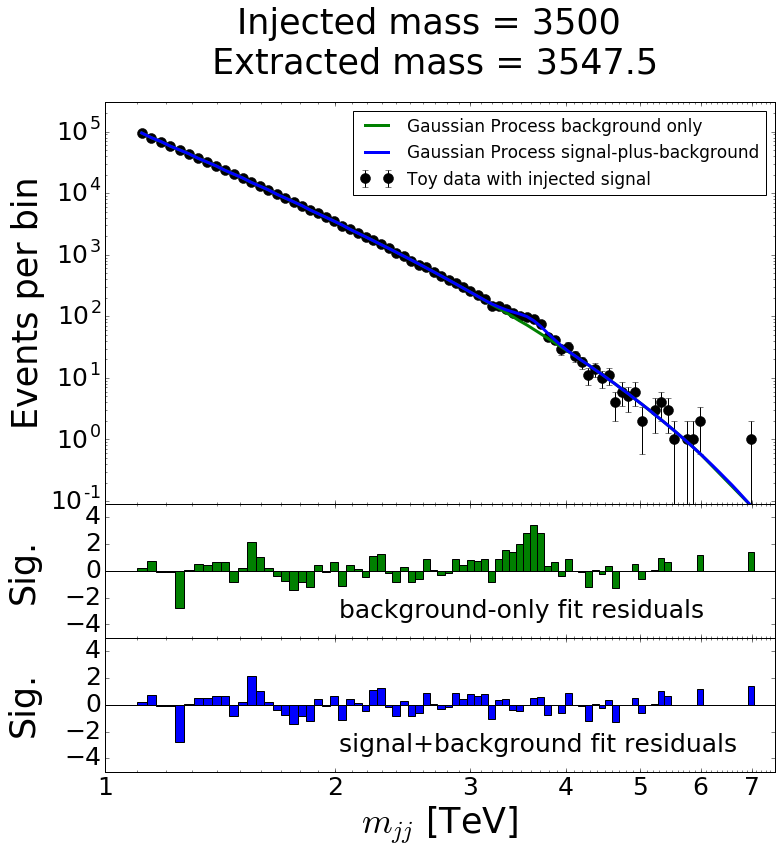

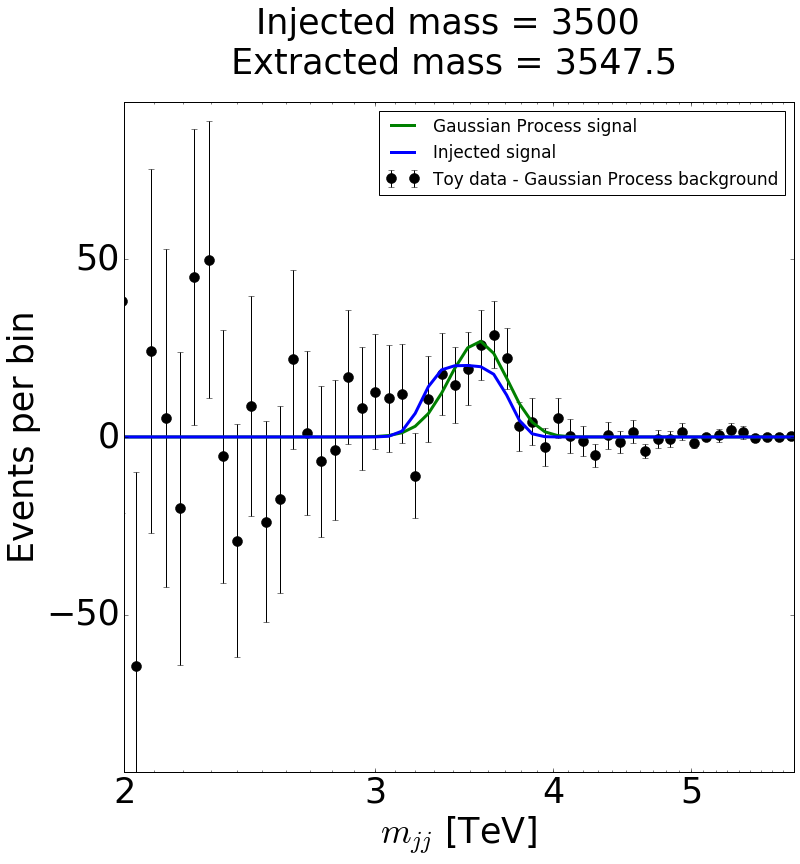

(29104.655098004776, 1230.4406340430655, 100.00000068858705, 15.749055018513303)
(29159.086936367665, 1230.8479222120218, 100.00000379460461, 16.175865541321258)
(747.3247941509784, 3547.48714180309, 165.21973868890387, 9999.217717448219)
(746.0021704230439, 3547.4938909494263, 165.19633298868195, 9998.578983530284)
(745.2776662034361, 3547.4766026686793, 165.2196783284865, 9999.97696069074)
A, mass, tau, L 745.277666203 3547.47660267 165.219678328 9999.97696069
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.3628928326


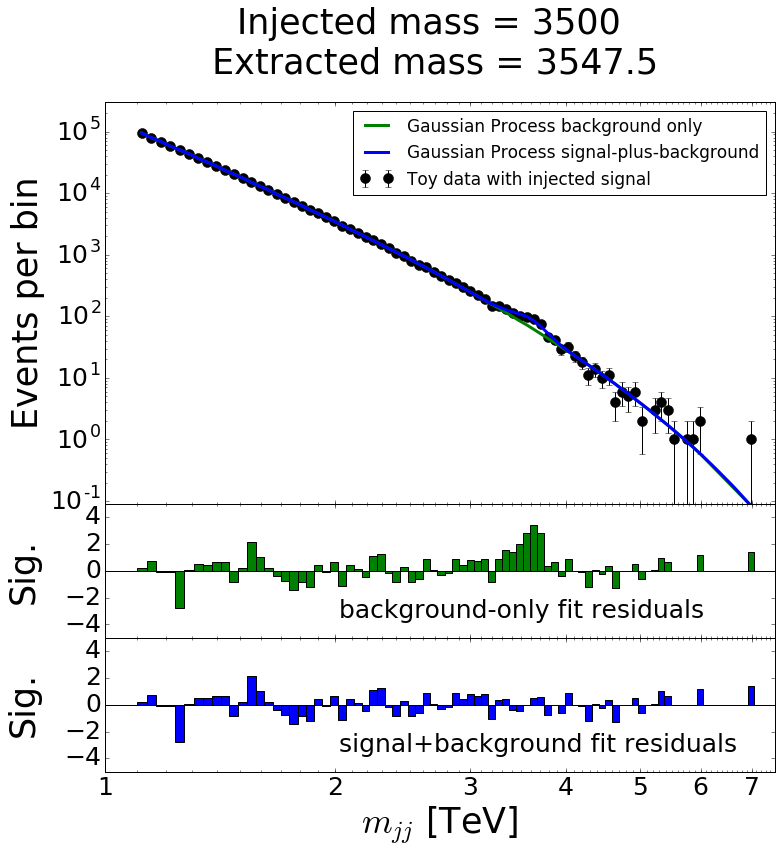

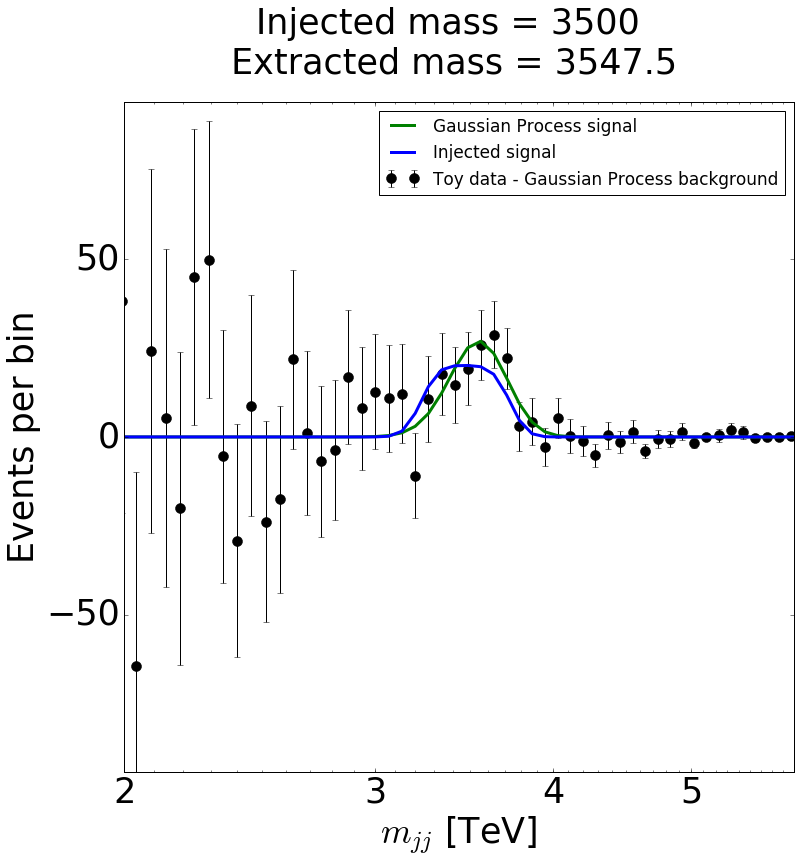

In [97]:
standardParamSets = [(20, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = square(truth_steps, n, m, w, truth_step_size)

        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
         
#############################
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
  
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)

#################################
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
  
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))

        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        newys, newxs = addZeros(mu2, xtoy)

        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)





parameters (300, 3500, 250)
(59.11053826223365, 2267.413231175626, 100.03439748129792, 49.99161917846598)
(283.0138851958716, 3514.4408619182714, 269.01983671042376, 9963.51821199986)
(283.8936501775335, 3514.72991746185, 268.8541606470367, 9995.1813257842)
(283.53090341246894, 3514.8919884774336, 268.8616181910262, 9999.884733445842)
(282.99371753480375, 3514.8914333625785, 268.89134904215143, 9999.942460737133)
A, mass, tau, L 282.993717535 3514.89143336 268.891349042 9999.94246074


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.0556846823


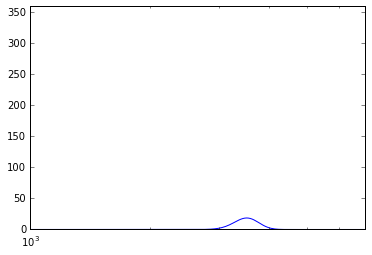

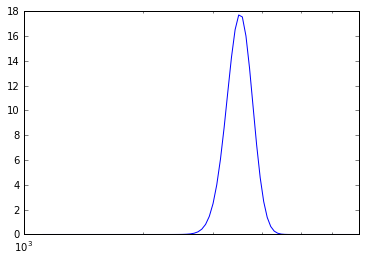

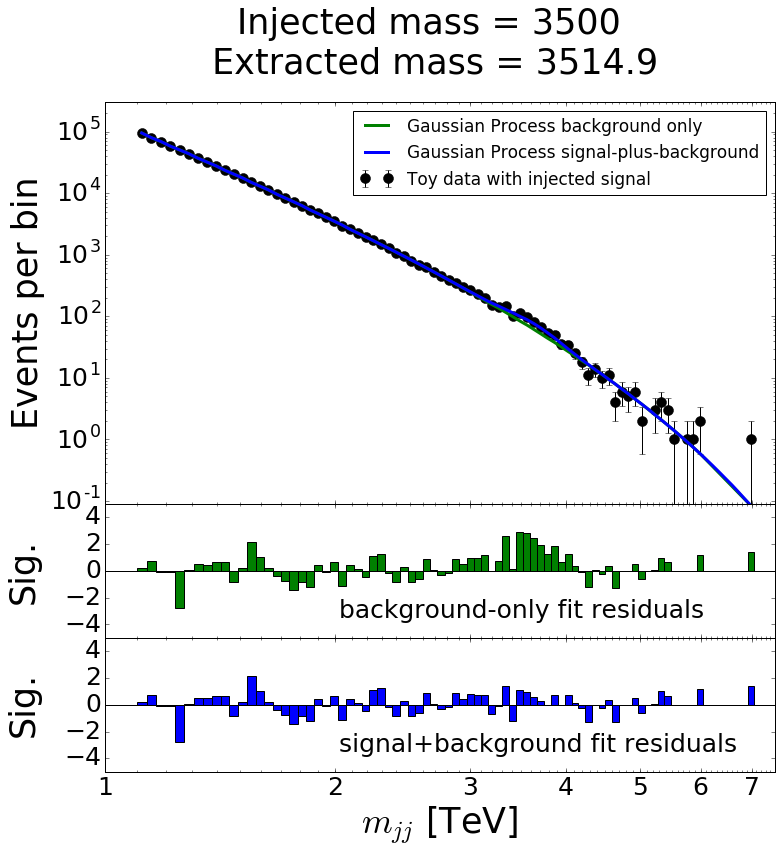

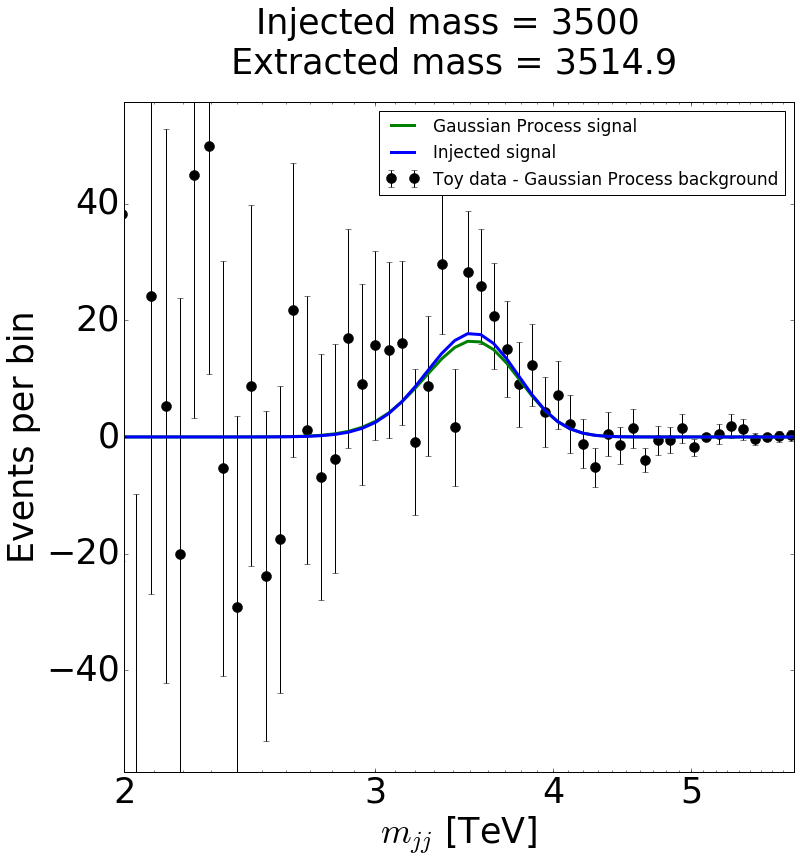

In [96]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

parameters (300, 3500, 250)
(59.11053826223365, 2267.413231175626, 100.03439748129792, 49.99161917846598)
(283.0138851958716, 3514.4408619182714, 269.01983671042376, 9963.51821199986)
(283.8936501775335, 3514.72991746185, 268.8541606470367, 9995.1813257842)
(283.53090341246894, 3514.8919884774336, 268.8616181910262, 9999.884733445842)
(282.99371753480375, 3514.8914333625785, 268.89134904215143, 9999.942460737133)
A, mass, tau, L 282.993717535 3514.89143336 268.891349042 9999.94246074


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.0556846823


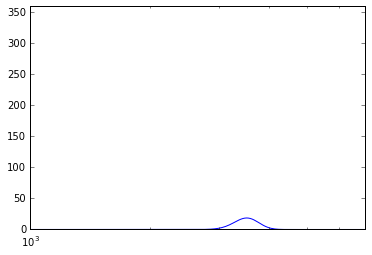

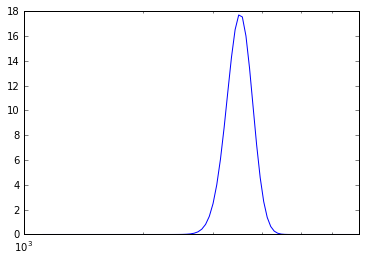

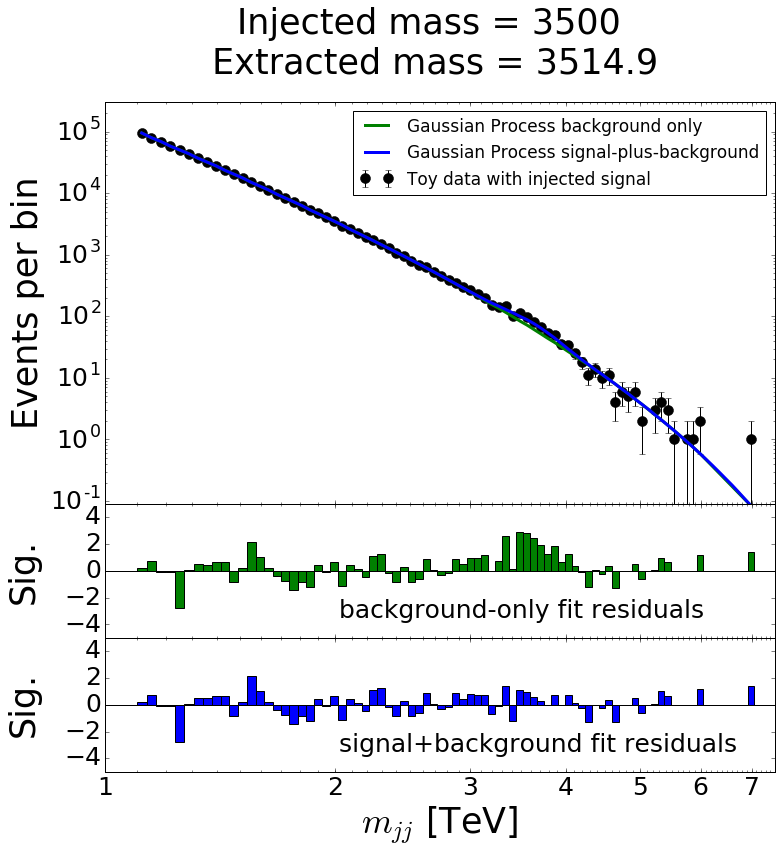

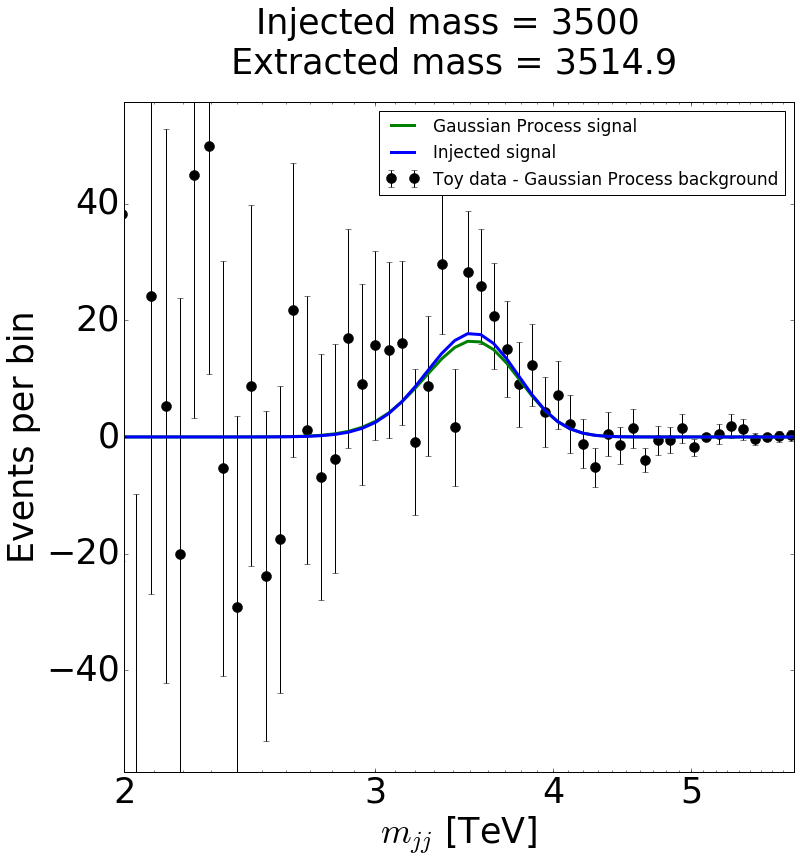

In [96]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

parameters (300, 3500, 250)
(59.11053826223365, 2267.413231175626, 100.03439748129792, 49.99161917846598)
(283.0138851958716, 3514.4408619182714, 269.01983671042376, 9963.51821199986)
(283.8936501775335, 3514.72991746185, 268.8541606470367, 9995.1813257842)
(283.53090341246894, 3514.8919884774336, 268.8616181910262, 9999.884733445842)
(282.99371753480375, 3514.8914333625785, 268.89134904215143, 9999.942460737133)
A, mass, tau, L 282.993717535 3514.89143336 268.891349042 9999.94246074


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.0556846823


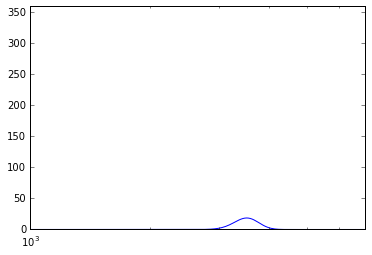

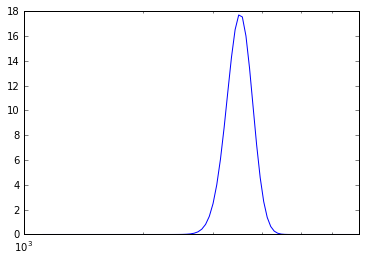

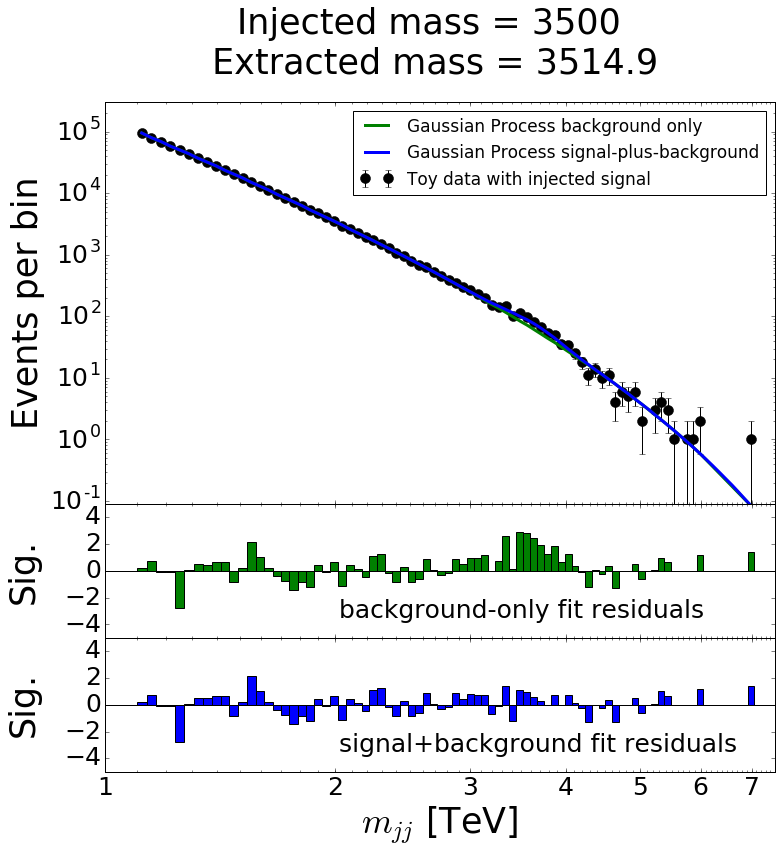

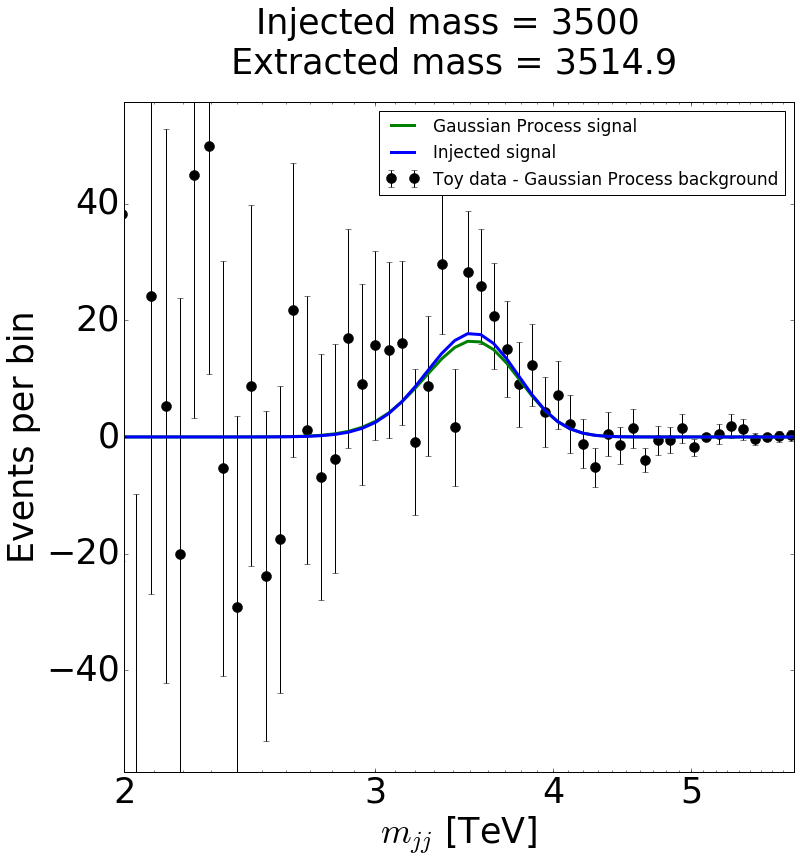

In [96]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

parameters (300, 3500, 250)
(59.11053826223365, 2267.413231175626, 100.03439748129792, 49.99161917846598)
(283.0138851958716, 3514.4408619182714, 269.01983671042376, 9963.51821199986)
(283.8936501775335, 3514.72991746185, 268.8541606470367, 9995.1813257842)
(283.53090341246894, 3514.8919884774336, 268.8616181910262, 9999.884733445842)
(282.99371753480375, 3514.8914333625785, 268.89134904215143, 9999.942460737133)
A, mass, tau, L 282.993717535 3514.89143336 268.891349042 9999.94246074


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.0556846823


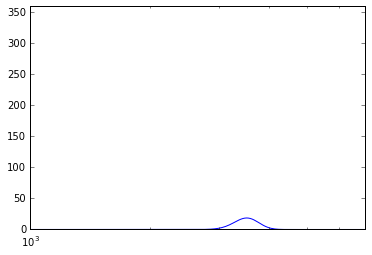

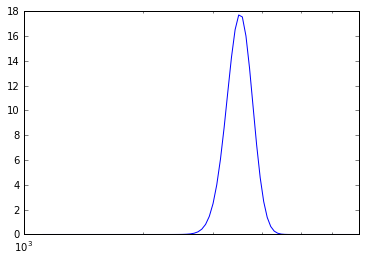

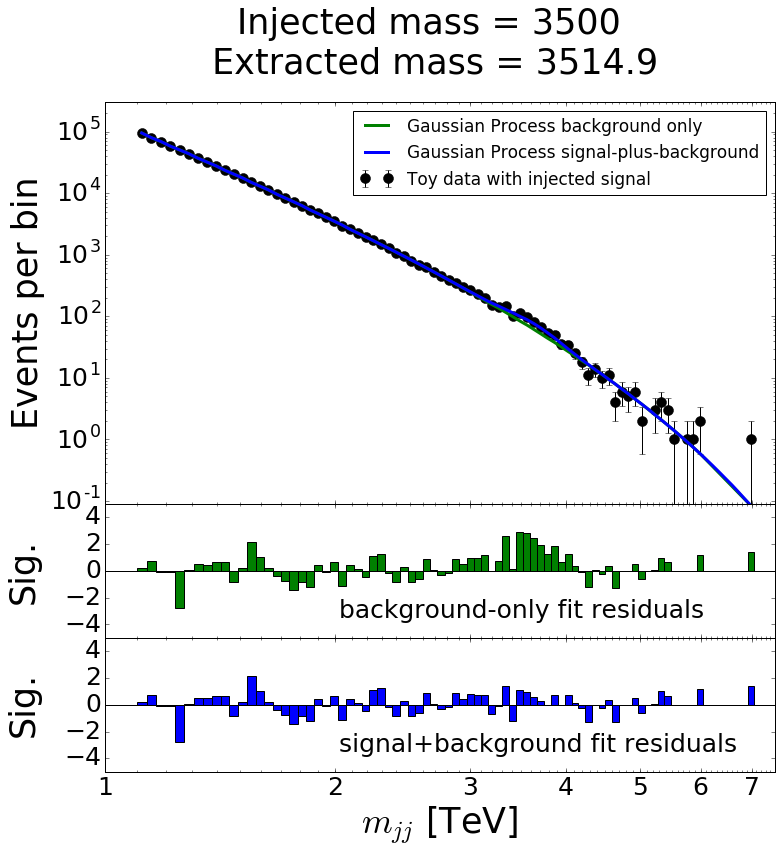

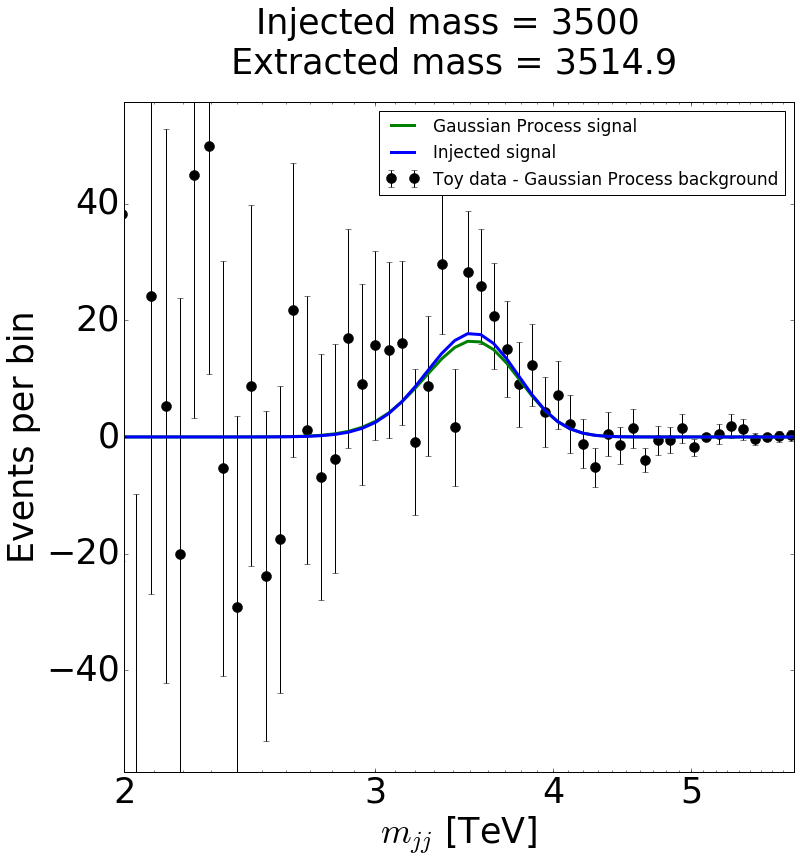

In [96]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

parameters (300, 3500, 250)
(59.11053826223365, 2267.413231175626, 100.03439748129792, 49.99161917846598)
(283.0138851958716, 3514.4408619182714, 269.01983671042376, 9963.51821199986)
(283.8936501775335, 3514.72991746185, 268.8541606470367, 9995.1813257842)
(283.53090341246894, 3514.8919884774336, 268.8616181910262, 9999.884733445842)
(282.99371753480375, 3514.8914333625785, 268.89134904215143, 9999.942460737133)
A, mass, tau, L 282.993717535 3514.89143336 268.891349042 9999.94246074


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.0556846823


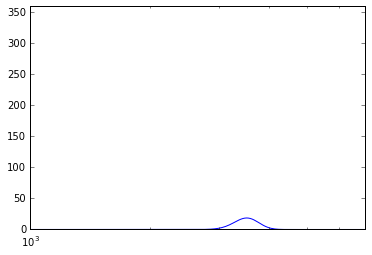

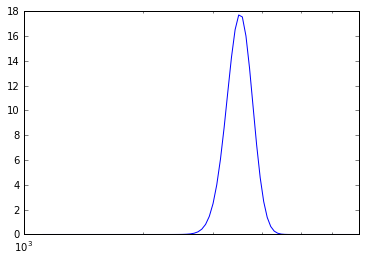

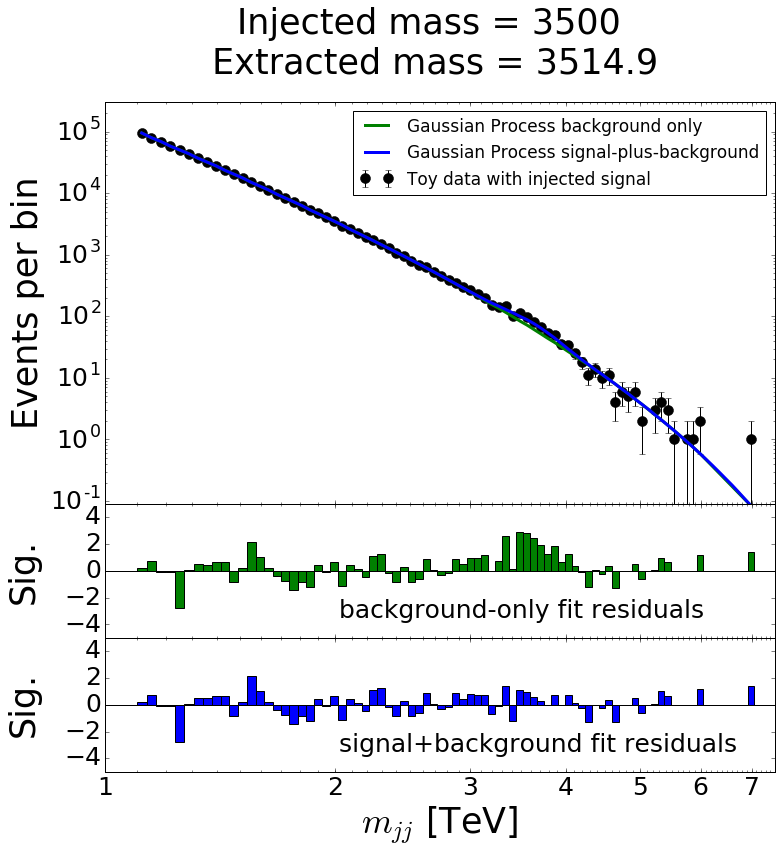

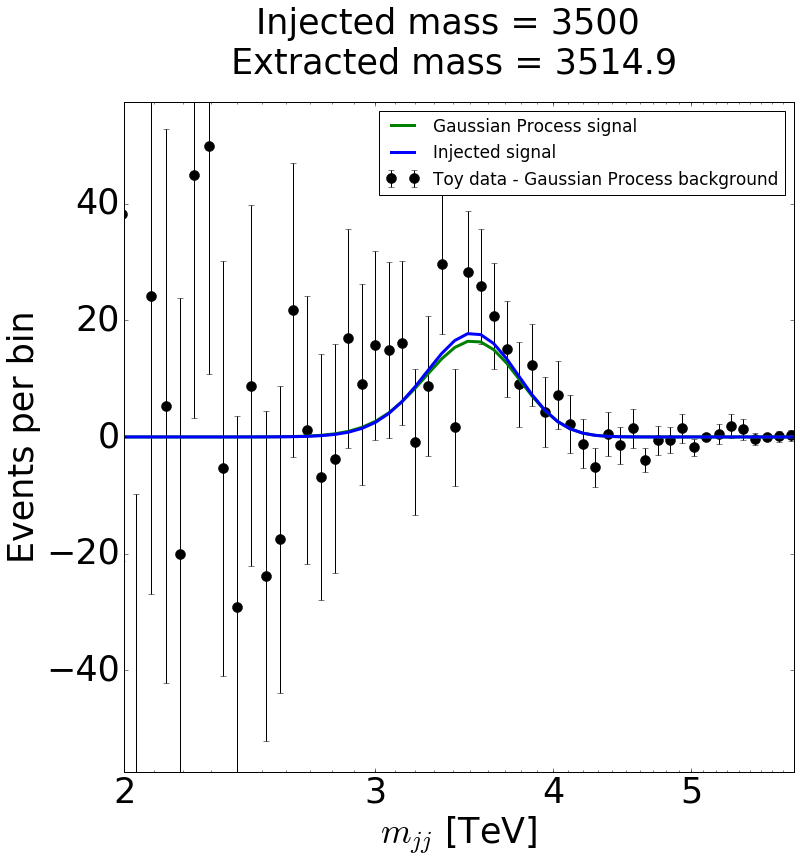

In [96]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

parameters (300, 3500, 250)
(59.11053826223365, 2267.413231175626, 100.03439748129792, 49.99161917846598)
(283.0138851958716, 3514.4408619182714, 269.01983671042376, 9963.51821199986)
(283.8936501775335, 3514.72991746185, 268.8541606470367, 9995.1813257842)
(283.53090341246894, 3514.8919884774336, 268.8616181910262, 9999.884733445842)
(282.99371753480375, 3514.8914333625785, 268.89134904215143, 9999.942460737133)
A, mass, tau, L 282.993717535 3514.89143336 268.891349042 9999.94246074


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.0556846823


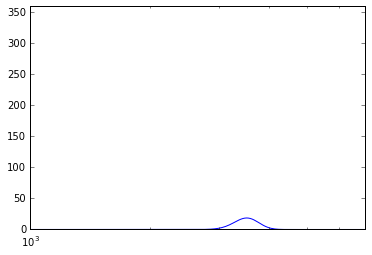

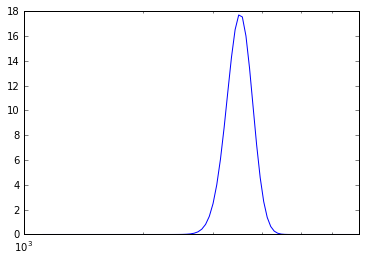

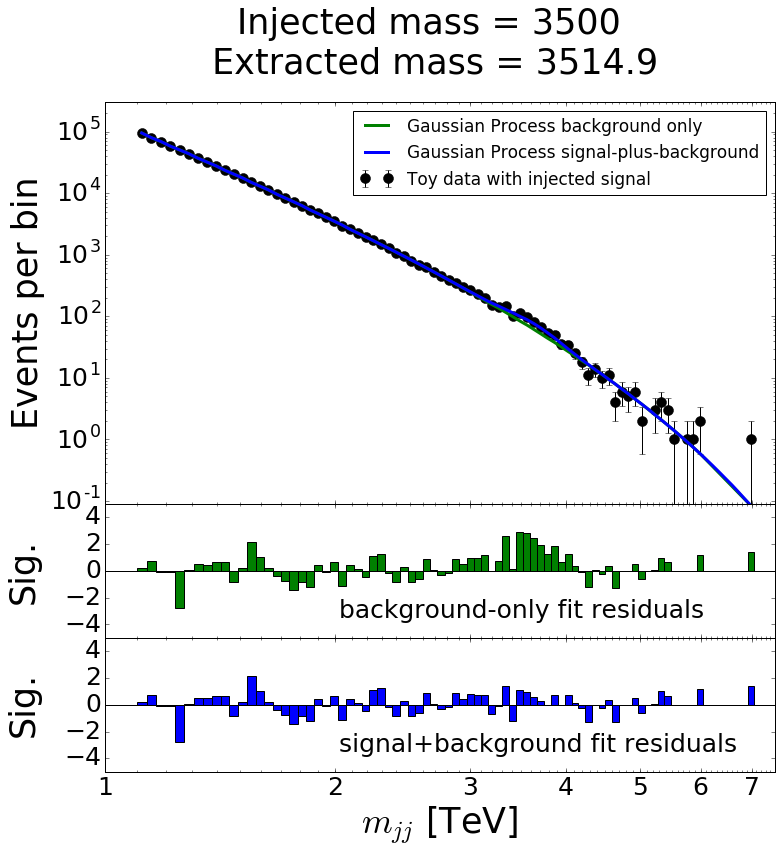

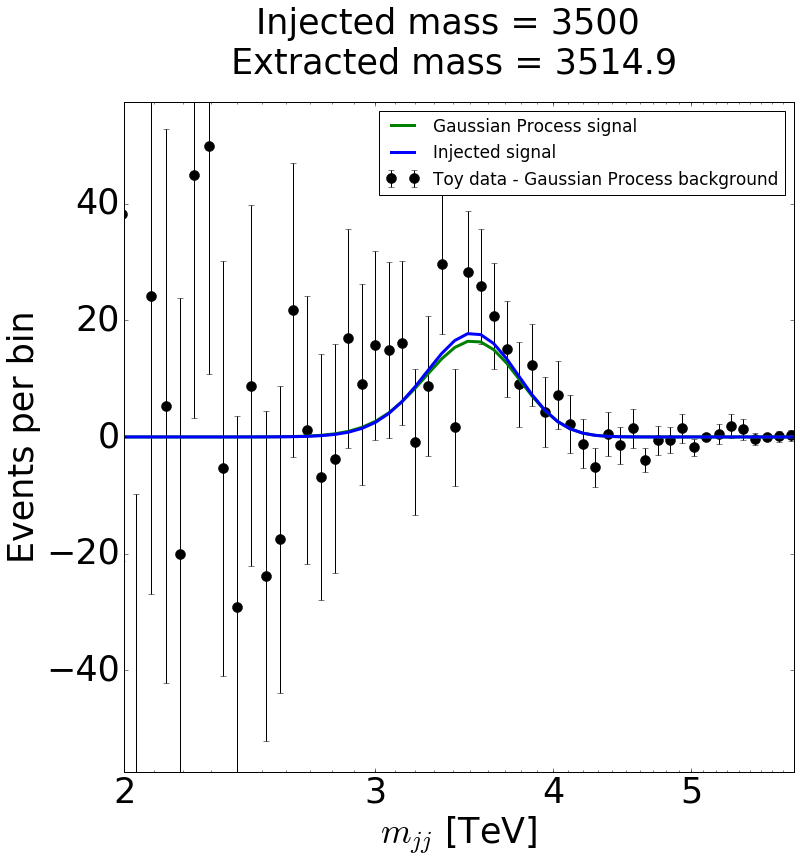

In [96]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

parameters (300, 3500, 250)
(59.11053826223365, 2267.413231175626, 100.03439748129792, 49.99161917846598)
(283.0138851958716, 3514.4408619182714, 269.01983671042376, 9963.51821199986)
(283.8936501775335, 3514.72991746185, 268.8541606470367, 9995.1813257842)
(283.53090341246894, 3514.8919884774336, 268.8616181910262, 9999.884733445842)
(282.99371753480375, 3514.8914333625785, 268.89134904215143, 9999.942460737133)
A, mass, tau, L 282.993717535 3514.89143336 268.891349042 9999.94246074


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.0556846823


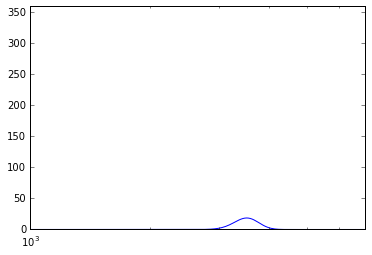

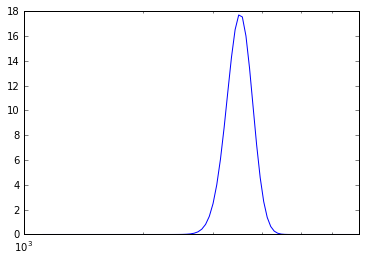

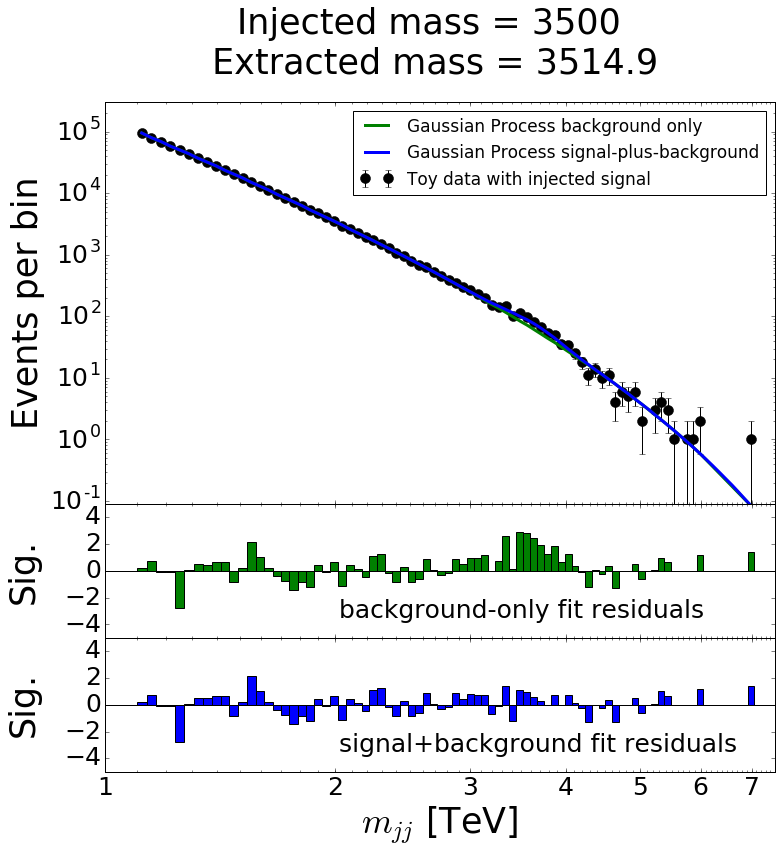

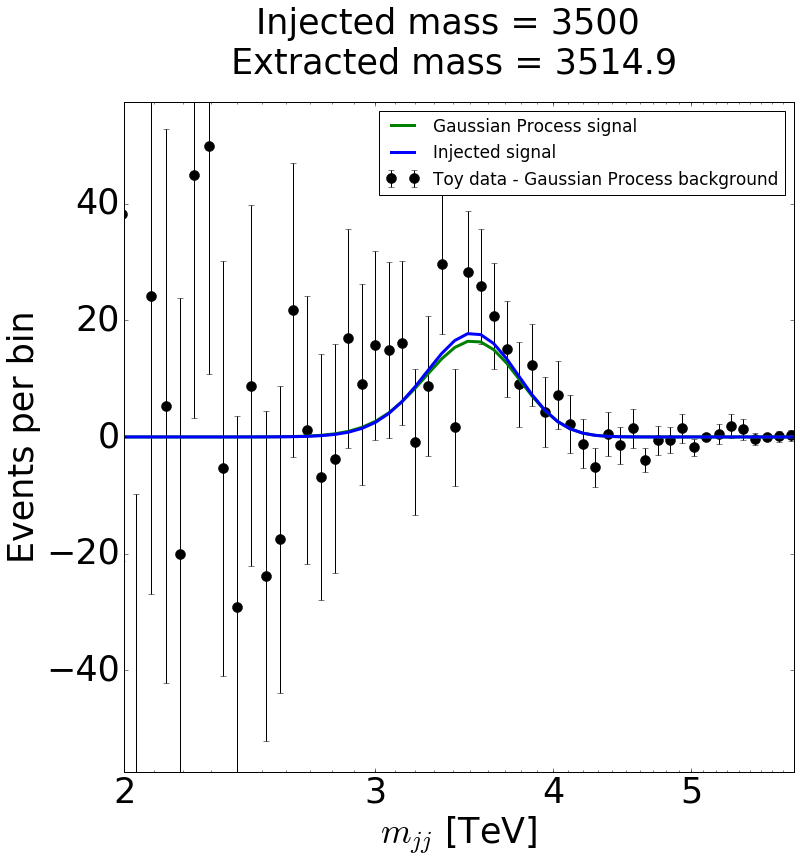

In [96]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

parameters (300, 3500, 250)
(59.11053826223365, 2267.413231175626, 100.03439748129792, 49.99161917846598)
(283.0138851958716, 3514.4408619182714, 269.01983671042376, 9963.51821199986)
(283.8936501775335, 3514.72991746185, 268.8541606470367, 9995.1813257842)
(283.53090341246894, 3514.8919884774336, 268.8616181910262, 9999.884733445842)
(282.99371753480375, 3514.8914333625785, 268.89134904215143, 9999.942460737133)
A, mass, tau, L 282.993717535 3514.89143336 268.891349042 9999.94246074


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 69.0556846823


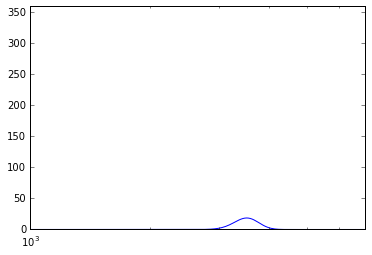

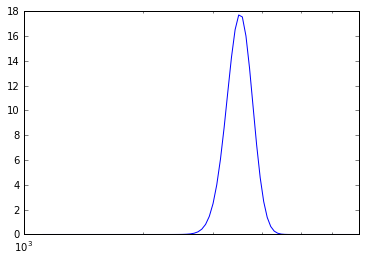

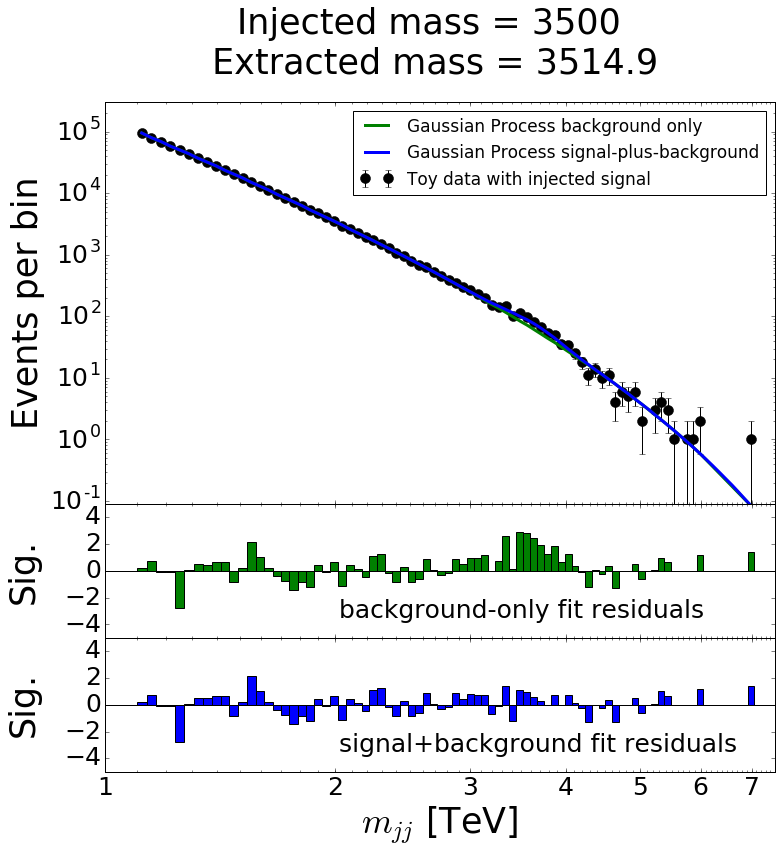

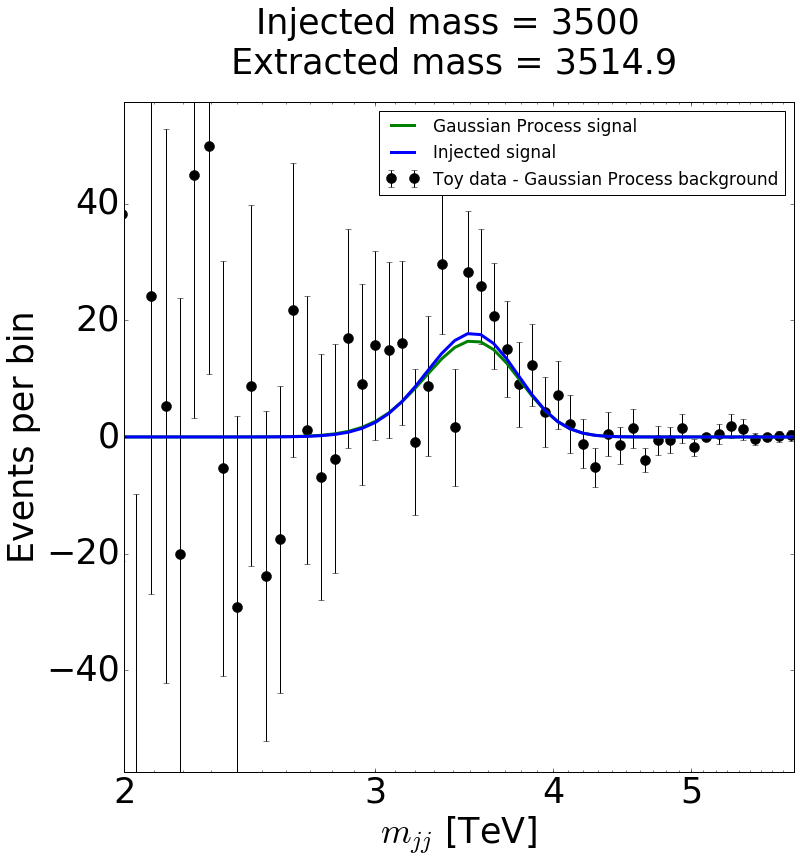

In [96]:

#standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
#                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet


    for i in range(1):
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        

        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsigNew(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsigNew_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau, L = best_fit_new 
 
        print "A, mass, tau, L", A, mass, tau, L
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        newy, newx = addZeros(mu1, xtoy)

        label="Injected mass = "+str(m)+"\n Extracted mass = "+str(round(mass,1))
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        newys, newxs = addZeros(mu2, xtoy)
        #makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        makePrettyPlots_signalOnly2(xvalO, ydataO-newy, newys, ydataO, smeared_countsO, m, label)
        

In [83]:
class logLike_gp_test:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, L):
        kernel = A * SignalKernel(m = mass, t = tau, L=L)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x,)# np.sqrt(abs(self.y)))
            return -gp.lnlikelihood(self.y)
        except:
            print "failed"
            return np.inf  
        
def fit_gp_test(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3.
        init1 = np.random.random() * 3.
        init2 = np.random.random() * 2.
        init3 = np.random.random() * 5.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 0.--1, error_mass = 0.001, error_tau = 0.001, error_L =0.001,
                  limit_A = (0.001, 10), limit_mass = (-10, 10), limit_tau = (0.01, 10), limit_L = (0.01, 100))
        fit = m.migrad()
        #print m.args
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args  
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

(3.6391530239742242, 2.391854852537975, 0.7837784371856328, 4.711150098515601)
(1.6659832284414604, 1.9710948303736782, 0.9167190978473808, 4.4410043416969325)
(9.687473059870728, -9.952498463153638, 3.1350998945686284, 0.02005548159615602)
(4.0737874489246115, 0.004000711949448288, 1.0768389784196934, 0.15768432083396214)
(9.989970377445319, -0.06789640754574755, 1.0515471532185678, 0.1700435283561891)
(9.977521098220297, 0.040824099618465226, 1.0456921930563532, 0.16906792466377538)
(9.999847733122145, -0.06458388761462608, 1.0675682269955737, 0.1697082476586123)
A, mass, tau, L 9.99984773312 -0.0645838876146 1.067568227 0.169708247659


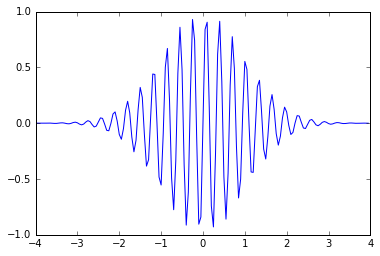

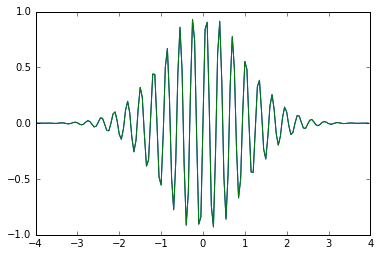

In [84]:

xtoy = np.arange(-4, 4, 0.05)        
    
signal = np.exp(-(xtoy)**2./2.) * np.sin(20.*xtoy)

plt.plot(xtoy, signal)


lnProb = logLike_gp_test(xtoy, signal, 0.1*np.ones(len(xtoy)))
bestval, best_fit_new = fit_gp_test(lnProb, False)
if np.isinf(bestval): 
    print "failed"

        
A, mass, tau, L = best_fit_new 
 
print "A, mass, tau, L", A, mass, tau, L
kernel = A * SignalKernel(m = mass, t = tau, L=L)

gp = george.GP(kernel)
gp.compute(xtoy)#, np.sqrt(abs(signal)))
meanGP = gp.predict( signal, xtoy)[0]

#makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
#makePrettyPlots_signalOnly2(xtoy, signal, meanGP, signal, signal, 1, label)
plt.figure()
plt.plot(xtoy, signal)
plt.plot(xtoy, meanGP)